In [31]:
import numpy as np
import random
from random import randint
import matplotlib.pyplot as plt
import gym
import time

import numpy as np
import matplotlib.pyplot as plt
import gym
import time

from collections import defaultdict

epsilon=0.05
alpha=0.01
gamma=1.0
np.random.seed(5467)


def prepFrozen(map_name=None):
    env = gym.make('FrozenLake-v0',desc=None,map_name=map_name)
    #env = gym.make('FrozenLake-v0',map_name='4x4')
    nA=env.nA
    nS=env.nS
    env.seed(48304)
    # 4x4 should use maxsteps=250
    # random 8x8 should use maxsteps=1000
    if map_name=='4x4':
        env._max_episode_steps = 250
    elif map_name=='8x8':
        env._max_episode_steps = 1000
    return env

# Here are the specifications of the Cart Pole Enviroment
#Observation:
#        Type: Box(4)
#        Num     Observation                 Min         Max
#        0 Cart Position             -4.8            4.8
#        1 Cart Velocity             -Inf            Inf
#        2 Pole Angle                 -24 deg        24 deg
#        3 Pole Velocity At Tip      -Inf            Inf
#
#    Actions:
#        Type: Discrete(2)
#        Num     Action
#        0 Push cart to the left
#        1 Push cart to the right
#
# function to discretize the continuous state space into integers


def discCP(state):
    
    def sigmoid(x):
        return 1/(1 + np.exp(-x))   
    
    x, x_dot, theta, theta_dot = state
    d=np.zeros(4,dtype=int)
    d[0]=np.floor((x+4.799)/0.96)
    d[1]=np.floor(sigmoid(x_dot)*9.99)
    d[2]=np.floor((theta+23.99)/4.8)
    d[3]=np.floor(sigmoid(theta_dot)*9.99)
    return d[0]+10*d[1]+100*d[2]+1000*d[3]


def prepCartPole(map_name=None):
    env = gym.make('CartPole-v0')
    env.seed(48304)
    nA=2
    nS=10000
    env._max_episode_steps = 500
    return env

In [32]:
class Agent:
    
    def __init__(self, num_states, num_actions, alpha, gamma, epsilon):
        self.num_states = num_states
        self.num_actions = num_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self._q_func = defaultdict(lambda: defaultdict(lambda: 0))

    def initialize(self, init_type='zeros', opt_val=None, rand_int=False):
        '''
        Initialize Q funciton either with zeros or using optimistic initialization
        Params:
            num_states (int): number of states in the env
            num_actions (int): number of actions in the env
            init_type (str): either 'zeros', 'optimistic' or 'random'
            opt_val (float): value for optimistic initialization
        '''
        #Initialize Q with zeros
        if init_type=='zeros':
            q_init = {s:{a:0for a in range(self.num_actions)} 
                      for s in range(self.num_states)}
        elif init_type=='optimistic':
            q_init = {s:{a:opt_val for a in range(self.num_actions)} 
                      for s in range(self.num_states)}
        elif init_type=='random':
            if rand_int==False:
                q_init = {s:{a:random.uniform(0, 1) for a in range(self.num_actions)} 
                          for s in range(self.num_states)}
            else:
                q_init = {s:{a:randint(0, 1000) for a in range(self.num_actions)} 
                          for s in range(self.num_states)}                
        
        self._q_func = q_init

        
    def take_e_action(self, state, reduced_epsilon=None):
        '''
        Takes action according to epsilon-greedy policy
        Params:
            epsilon (float): epsilon
            state (int): observed state
            reduced_epsilon (float): epsilon value reduced over time
        Returns action (int): action according to the e-greedy
        '''
        
        if reduced_epsilon!=None:
            action_probs = np.ones(self.num_actions, dtype = float)*\
                        reduced_epsilon/self.num_actions
            best_action = max(self._q_func[state], key = lambda x:self._q_func[state][x])
            action_probs[best_action] += (1.0 - reduced_epsilon)        
            action = np.random.choice(np.arange(len(action_probs)),
                                      p = action_probs) 
            
        else:
            action_probs = np.ones(self.num_actions, dtype = float)*\
                            self.epsilon/self.num_actions
            best_action = max(self._q_func[state], key = lambda x:self._q_func[state][x])
            action_probs[best_action] += (1.0 - self.epsilon)
            action = np.random.choice(np.arange(len(action_probs)),
                                      p = action_probs) 

        return action
    
    def update_qfunc(self, state, action, reward, next_state, next_action, terminal=False):
        '''
        Updates Q(S_t, A_t)
        Params:
            state (int): state at time step t
            action (int): action at time step t
            reward (float): reward at t
            next_state (int): state at t+1
            next_action (int): action at t+1
            terminal (bool): whether the next state is terminal or not
        '''
        
        if not terminal:
            #if S_t+1 non-terminal update according to
            # delta = r_t+gamma*Q(S_next, A_next) - Q(S_t, A_t)
            self._q_func[state][action]+=self.alpha*(reward+self.gamma*\
                                                     self._q_func[next_state][next_action]-\
                                                     self._q_func[state][action])
        else:
            # if S_t+1 is terminal update according to 
            # delta = r_t - Q(S_t, A_t)
            self._q_func[state][action]+=self.alpha*(reward - self._q_func[state][action])
            
    def print_qfunc(self):
        print(self._q_func)
        
    def get_best_policy(self):
        '''
        Calculate Greedy policy for evaluation
        '''
        best_pi = {}
        q = self._q_func
        for state in q:
            best_pi[state] = max(q[state], key=lambda k:q[state][k])
            
        return best_pi

## Implement SARSA

In [38]:
## Write func for SARSA

def run_sarsa(env_name, num_episodes, alpha, gamma, epsilon, epsilon_decay=None,
              init_type='zeros', opt_value=None, render=False, rand_int=False):
    
    '''
    Runs SARSA algorithm on the particular environment.
    Params:
        env_name (str): name of the environment
        num_episodes (int): number of episodes to run
        alpha (float): alpha
        gamma (float): discount factor
        epsilon (float): epsilon for e-Greedy
        epsilon_decay (float): decay of the epsilon over time used in e-greedy policy
                             e.g. 0.5 default None
        
        init_type (str): type of initialization of Q(s,a). 'random', 'zeros', 
                        'optimistic'
        opt_value (float): value to initialize optimistic starts
        render (bool): set True if you wish to render the env
        
    Returns:
        best greedy policy (dict)
    '''
    
    ##Helper functions##
    
    def reduce_epsilon(curr_epsilon, decay):
        '''
        Reduces epsilon over time (per time step)
        Params: 
            epsilon (float):current epsilon [0, 1]
            decay (float): how much epsilon should be reduced [0, 1]
        '''
        
        reduced = curr_epsilon - decay
        if reduced >= 0.05:
            return reduced
        else:
            return curr_epsilon
        
    ###Env types####
    if env_name=='frozen4x4':
        env = prepFrozen('4x4')
        num_states, num_actions = env.observation_space.n, env.action_space.n
        agent=Agent(num_states, num_actions, alpha, gamma, epsilon)
    elif env_name=='frozen8x8':
        env = prepFrozen('8x8')
        num_states, num_actions = env.observation_space.n, env.action_space.n
        agent=Agent(num_states, num_actions, alpha, gamma, epsilon)
    elif env_name=='cartpole':
        env = prepCartPole()
        num_states, num_actions = (10000, 2)
        agent=Agent(num_states, num_actions, alpha, gamma, epsilon)
        
    #Initialize Q(s,a)   
    ###Init types####
 
    if init_type=='optimistic':
        agent.initialize(init_type, opt_value)
    else:
        agent.initialize(init_type, rand_int)
    #####Reward vec for evaluation #######
    
    eval_rewards = []
    episode_count = 0
    
    print('Start training...')    
    for ep in range(num_episodes):
        #Count episodes to run evaluation periodically
        episode_count+=1
        
       # print(f"Episode: {ep}")
        
        #Discrete state for cart pole
        if env_name=='cartpole':
            state = discCP(env.reset())
        else:
            state = env.reset()
        action = agent.take_e_action(state)
        
        if epsilon_decay:
            epsilon = reduce_epsilon(epsilon, epsilon_decay)
        
        done = False
        t=0
        while True:
            t+=1
            if render:
                env.render()
            next_state, reward, done, info = env.step(action)
        
            #Disc state for cart pole
            if env_name=='cartpole':
                next_state = discCP(next_state)                
            
            next_action = agent.take_e_action(next_state, epsilon)
        
            #Update q_function
            agent.update_qfunc(state, action, reward, next_state, next_action, done)
            
            #Update S and A
            state = next_state
            action = next_action
            
            if done:
                #print(f"Episode: {ep} finished after {t+1} timesteps")
                #print('---------------------------------------------')
                break
        ###Evaluation###
        #Run every 50 episodes
        if episode_count%50 == 0:
            #print(f"Evaluating on episode {episode_count}...")
            greedy_pi = agent.get_best_policy()
            #Run eval function
            avg_reward = eval_sarsa(env, env_name, greedy_pi)
            
            eval_rewards.append(avg_reward)
        
    env.close()
    return eval_rewards

In [6]:
def eval_sarsa(env, env_name, greedy_pi):
    
    '''
    Runs evaluation during SARSA execution
    Params:
        env: current environment
        env_name (string): name of the current env
        greedy_pi (dict): greedy policy extracted on the current iteration of SARSA
    Returns:
        (int): average reward per SARSA training episode
    '''
    
    cumulative_reward = 0
    
    for ep in range(100):
        if env_name=='cartpole':
            state = discCP(env.reset())
        else:
            state = env.reset()
        
        t = 0
        done = False
        step_reward = 0
        
        while True:
            t+=1
            #Take greedy action using extracted pi
            action = greedy_pi[state]            
            state, reward, done, info = env.step(action)
            
            if env_name=='cartpole':
                state = discCP(state)

            step_reward+=reward
            if done or t > 500:
                break           
        cumulative_reward+=step_reward
        #print(f"Eval episode {ep} finished after {t} timesteps")
    return cumulative_reward/100

## Run SARSA with different paramenters and extract the policy

We will run SARSA with different parameter configurations and take zero initialization as a baseline for the following experiments. Further we are going to test the influence of **Optimistic initialization** and **Epsilon decay** to evaluate different exploration strategies. For evaluation we extract *Greedy* policy generated by SARSA although we used $\epsilon-Greedy$ during the training.

**Default configuration:**

- Number of episodes: 5000
- $\epsilon = 0.05$
- $\alpha = 0.01$
- $\gamma = 1$ (no discount)
- Initialization: zero

Parameters will be applied and evaluated for all the 
**environments:**

1. Frozen 4x4
2. Frozen 8x8
3. Cart Pole


**Experiments:**

1. Optimistic initialization (0.2, 0.5, 0.8) for FrozenLake environments and (50, 100, 300) for CartPole environment;
2. Epsilon decay over time steps:
    - Slow decay: 0.0001
    - Steep decay: 0.01
    - Medium decay: 0.001

## 1. Zero Initialization (No exploration)
With no or very low degree of exploration (with default  $\epsilon=0.05$) we receive no reward at all meaning SARSA does not converge.

In [146]:
zero4x4_r =  run_sarsa('frozen4x4', 5000, alpha, gamma, epsilon)
zero8x8_r =  run_sarsa('frozen8x8', 5000, alpha, gamma, epsilon)
zero_cart_r =  run_sarsa('cartpole', 5000, alpha, gamma, epsilon)

Start training...
Start training...


/home/anakuz/miniconda3/envs/reinf/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Start training...


In [147]:
zero4x4_r

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [4]:
def plot_performance(values, labels, env_name):
    plt.figure(figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
    x = [i*50 for i in range(len(values[0]))]
    for v, l in zip(values, labels):
        plt.plot(x, v, label=l)
    plt.xlabel('Episodes')
    plt.ylabel('Average reward')
    plt.legend()
    plt.title(env_name)
    plt.savefig(env_name+'.png')
    plt.show()

## 2. Optimistic 

In [25]:
##Frozen 4x4
opt_low_4x4_r = run_sarsa('frozen4x4', 5000, alpha, gamma, epsilon, init_type='optimistic', opt_value=0.2)
opt_med_4x4_r = run_sarsa('frozen4x4', 5000, alpha, gamma, epsilon, init_type='optimistic', opt_value=0.5)
opt_high_4x4_r = run_sarsa('frozen4x4', 5000, alpha, gamma, epsilon, init_type='optimistic', opt_value=0.8)

Start training...
Start training...
Start training...


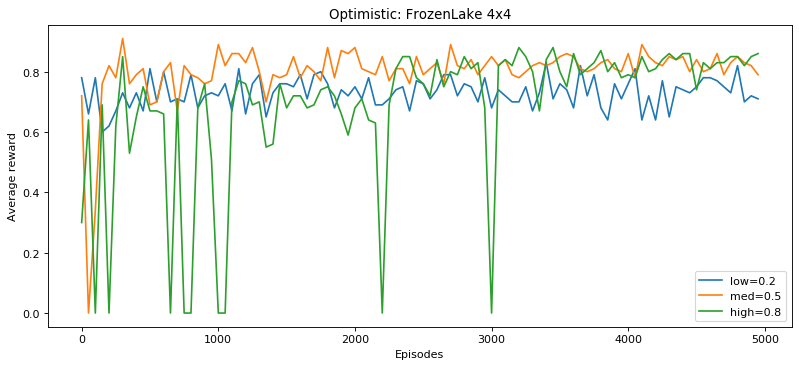

In [26]:
plot_performance([opt_low_4x4_r, opt_med_4x4_r, opt_high_4x4_r], 
                 ['low=0.2', 'med=0.5', 'high=0.8'], 'Optimistic: FrozenLake 4x4')

In [13]:
##Frozen 8x8

opt_low_8x8_r = run_sarsa('frozen8x8', 5000, alpha, gamma, epsilon, init_type='optimistic', opt_value=0.2)
opt_med_8x8_r = run_sarsa('frozen8x8', 5000, alpha, gamma, epsilon, init_type='optimistic', opt_value=0.5)
opt_high_8x8_r = run_sarsa('frozen8x8', 5000, alpha, gamma, epsilon, init_type='optimistic', opt_value=0.8)

Start training...
Start training...
Start training...


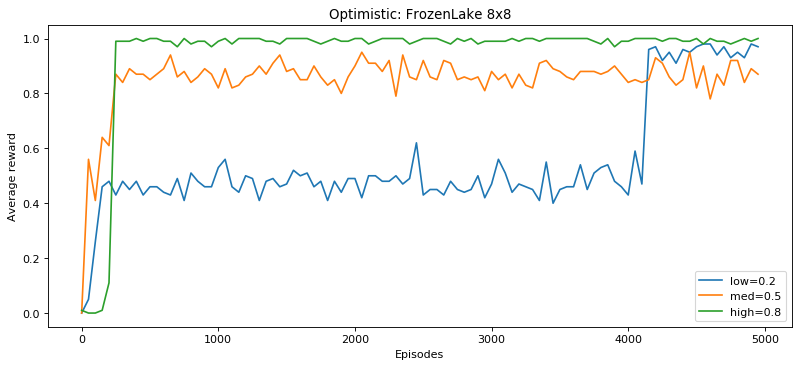

In [14]:
plot_performance([opt_low_8x8_r, opt_med_8x8_r, opt_high_8x8_r], 
                 ['low=0.2', 'med=0.5', 'high=0.8'], 'Optimistic: FrozenLake 8x8')

In [15]:
##Frozen 8x8

opt_low_8x8_r10 = run_sarsa('frozen8x8', 10000, alpha, gamma, epsilon, init_type='optimistic', opt_value=0.2)
opt_med_8x8_r10 = run_sarsa('frozen8x8', 10000, alpha, gamma, epsilon, init_type='optimistic', opt_value=0.5)
opt_high_8x8_r10 = run_sarsa('frozen8x8', 10000, alpha, gamma, epsilon, init_type='optimistic', opt_value=0.8)

Start training...
Start training...
Start training...


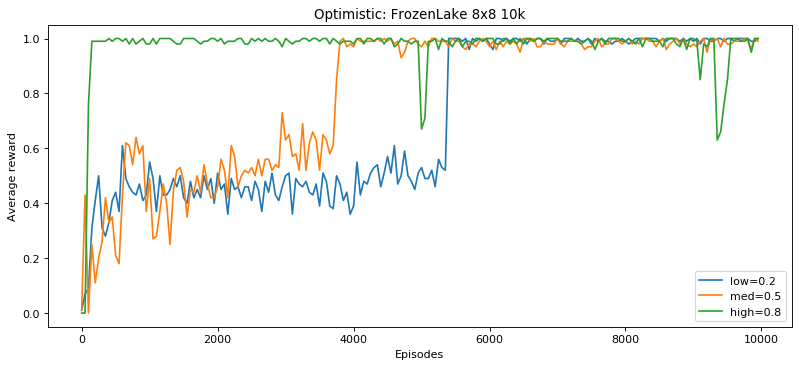

In [16]:
plot_performance([opt_low_8x8_r10, opt_med_8x8_r10, opt_high_8x8_r10], 
                 ['low=0.2', 'med=0.5', 'high=0.8'], 'Optimistic: FrozenLake 8x8 10k')

In [17]:
## CartPole 
opt_low_cart_r = run_sarsa('cartpole', 5000, alpha, gamma, epsilon, init_type='optimistic', opt_value=50)
opt_med_cart_r = run_sarsa('cartpole', 5000, alpha, gamma, epsilon, init_type='optimistic', opt_value=100)
opt_high_cart_r = run_sarsa('cartpole', 5000, alpha, gamma, epsilon, init_type='optimistic', opt_value=300)

/home/anakuz/miniconda3/envs/reinf/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Start training...
Start training...
Start training...


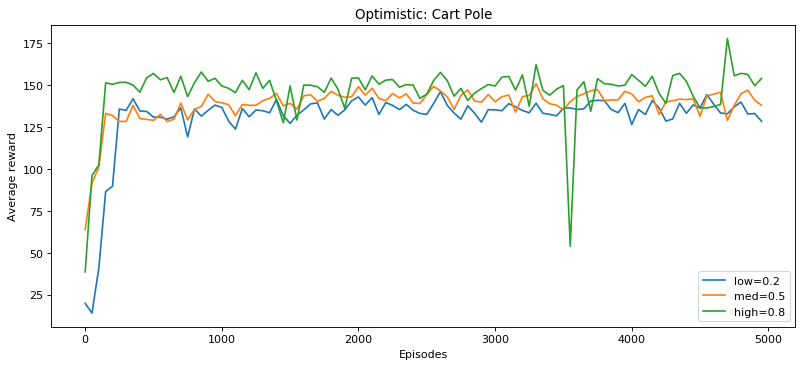

In [18]:
plot_performance([opt_low_cart_r, opt_med_cart_r, opt_high_cart_r], 
                 ['low=0.2', 'med=0.5', 'high=0.8'], 'Optimistic: Cart Pole')

In [19]:
## CartPole 
opt_low_cart_r10 = run_sarsa('cartpole', 10000, alpha, gamma, epsilon, init_type='optimistic', opt_value=50)
opt_med_cart_r10 = run_sarsa('cartpole', 10000, alpha, gamma, epsilon, init_type='optimistic', opt_value=100)
opt_high_cart_r10 = run_sarsa('cartpole', 10000, alpha, gamma, epsilon, init_type='optimistic', opt_value=300)

Start training...
Start training...
Start training...


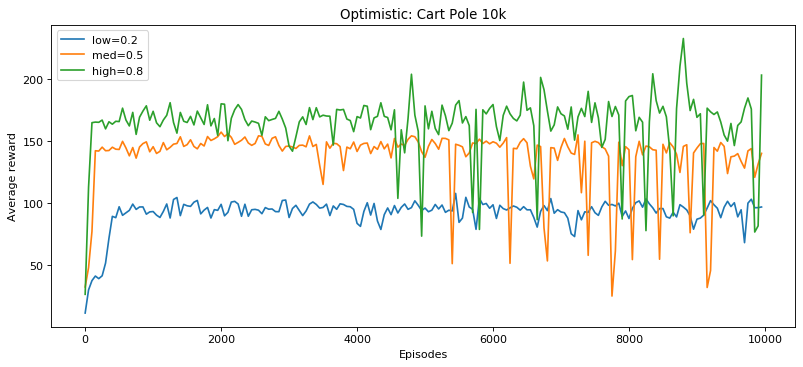

In [20]:
plot_performance([opt_low_cart_r10, opt_med_cart_r10, opt_high_cart_r10], 
                 ['low=0.2', 'med=0.5', 'high=0.8'], 'Optimistic: Cart Pole 10k')

## 3. Epsilon Decay

In [21]:
#FrozenLake 4x4 epsilon decay
dec_slow_4x4_r = run_sarsa('frozen4x4', 10000, alpha, gamma, 1, epsilon_decay=0.0001)
dec_steep_4x4_r = run_sarsa('frozen4x4', 10000, alpha, gamma, 1, epsilon_decay=0.01)
dec_med_4x4_r = run_sarsa('frozen4x4', 10000, alpha, gamma, 1, epsilon_decay=0.001)

Start training...
Start training...
Start training...


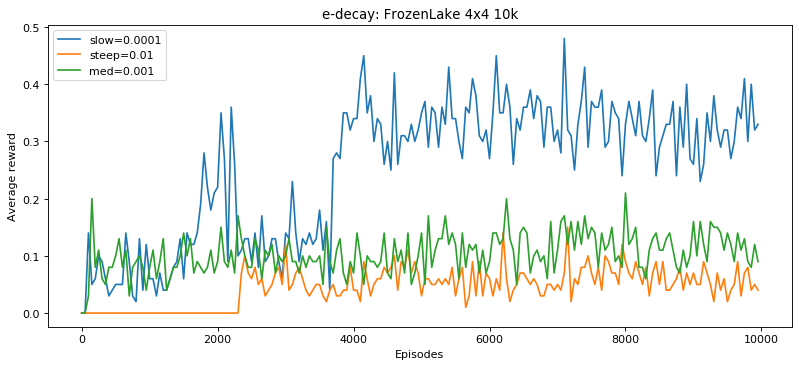

In [22]:
plot_performance([dec_slow_4x4_r, dec_steep_4x4_r, dec_med_4x4_r], 
                 ['slow=0.0001', 'steep=0.01', 'med=0.001'], 'e-decay: FrozenLake 4x4 10k')

In [27]:
dec_slow_8x8_r = run_sarsa('frozen8x8', 10000, alpha, gamma, 1, epsilon_decay=0.0001)
dec_med_8x8_r = run_sarsa('frozen8x8', 10000, alpha, gamma, 1, epsilon_decay=0.001)
dec_steep_8x8_r = run_sarsa('frozen8x8', 10000, alpha, gamma, 1, epsilon_decay=0.01)

Start training...
Start training...
Start training...


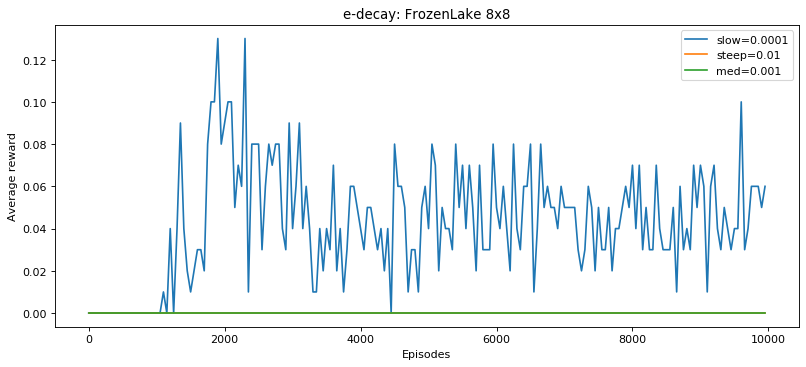

In [28]:
plot_performance([dec_slow_8x8_r, dec_steep_8x8_r, dec_med_8x8_r], 
                 ['slow=0.0001', 'steep=0.01', 'med=0.001'], 'e-decay: FrozenLake 8x8')

In [144]:
dec_slow_cart_r = run_sarsa('cartpole', 5000, alpha, gamma, 1, epsilon_decay=0.0001)
dec_med_cart_r = run_sarsa('cartpole', 5000, alpha, gamma, 1, epsilon_decay=0.001)
dec_steep_cart_r = run_sarsa('cartpole', 5000, alpha, gamma, 1, epsilon_decay=0.01)

/home/anakuz/miniconda3/envs/reinf/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Start training...
Start training...
Start training...


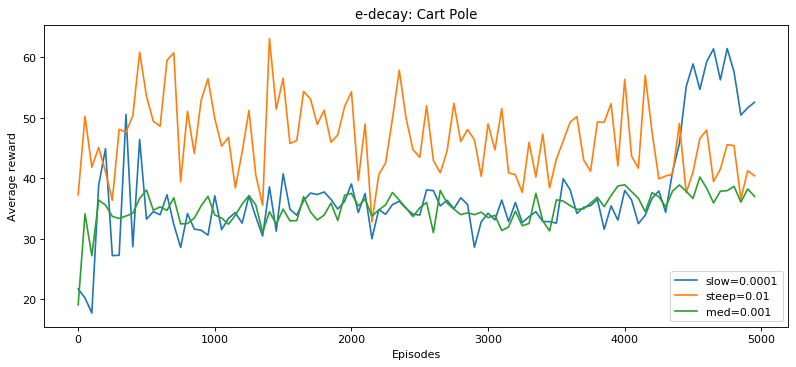

In [145]:
plot_performance([dec_slow_cart_r, dec_steep_cart_r, dec_med_cart_r], 
                 ['slow=0.0001', 'steep=0.01', 'med=0.001'], 'e-decay: Cart Pole')

In [150]:
dec_slow_cart_r10 = run_sarsa('cartpole', 10000, alpha, gamma, 1, epsilon_decay=0.0001)
dec_med_cart_r10 = run_sarsa('cartpole', 10000, alpha, gamma, 1, epsilon_decay=0.001)
dec_steep_cart_r10 = run_sarsa('cartpole', 10000, alpha, gamma, 1, epsilon_decay=0.01)

/home/anakuz/miniconda3/envs/reinf/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Start training...
Start training...
Start training...


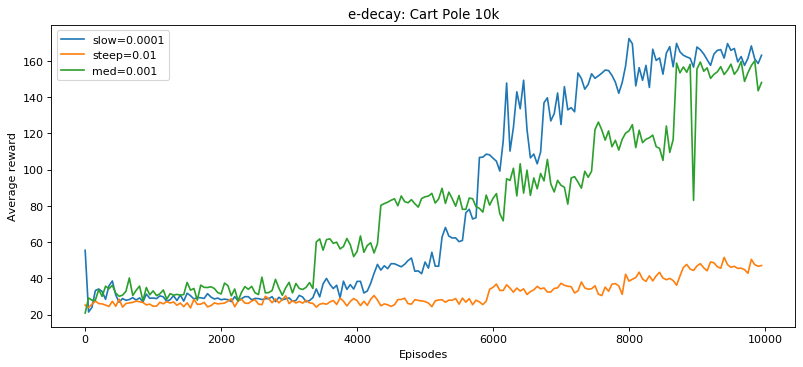

In [151]:
plot_performance([dec_slow_cart_r10, dec_steep_cart_r10, dec_med_cart_r10], 
                 ['slow=0.0001', 'steep=0.01', 'med=0.001'], 'e-decay: Cart Pole 10k')

In [39]:
#rand4x4_r =  run_sarsa('frozen4x4', 10000, alpha, gamma, epsilon)
#rand8x8_r =  run_sarsa('frozen8x8', 10000, alpha, gamma, epsilon)
rand_cart_r =  run_sarsa('cartpole', 10000, alpha, gamma, epsilon, rand_int=True)

/home/anakuz/miniconda3/envs/reinf/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Start training...


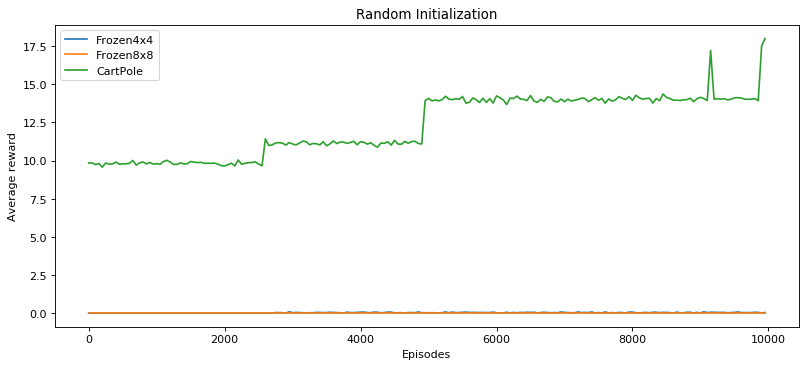

In [40]:
plot_performance([rand4x4_r, rand8x8_r, rand_cart_r], 
                 ['Frozen4x4', 'Frozen8x8', 'CartPole'], 'Random Initialization')